# **DATA MODELLING**

This notebook loads all **accident.csv** files from the directory structure:
`data/data_accidents/<YEAR>/accident.csv`

It processes each year and generates a new file:
`data/data_accidents/total_crashes.csv`

`total_crashes.csv` contains the following columns:
- `state` - State code
- `year` - Year of dataset
- `total_crashes` - Number of fatal crashes in that year (count of accident records)


### Load Data Paths

In [3]:
import os
import pandas as pd
from pathlib import Path

import seaborn as sns
from tqdm import tqdm
import requests
import time
import json
import hashlib
import openmeteo_requests
import requests_cache
from retry_requests import retry
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

project_root = Path(os.getcwd()).parents[0]
data_folder = project_root / 'data' / 'data_accidents'

### Generate `total_crashes.csv` for Each Year

In [4]:
all_years = []

years = sorted([f for f in data_folder.iterdir() if f.is_dir()])

for year_folder in tqdm(years, desc="Processing years", unit="year"):
    year = year_folder.name
    acc_file = year_folder / 'accident.csv'

    if not acc_file.exists():
        tqdm.write(f"Missing accident.csv for {year}, skipping")
        continue

    try:
        df = pd.read_csv(acc_file, low_memory=False, encoding="utf-8")
    except UnicodeDecodeError:
        df = pd.read_csv(acc_file, low_memory=False, encoding="latin1")

    if 'STATE' not in df.columns:
        tqdm.write(f"No STATE column found in {year}, skipping")
        continue

    total = df.groupby('STATE').size().reset_index(name='total_crashes')
    total['year'] = int(year)
    total.rename(columns={'STATE': 'state'}, inplace=True)

    all_years.append(total)

df_total = pd.concat(all_years, ignore_index=True)

df_total = df_total.sort_values(["year", "state"])

out_path = data_folder / "total_crashes.csv"
df_total.to_csv(out_path, index=False)

print(f"\nCombined file saved to: {out_path}")


Processing years: 100%|██████████| 52/52 [00:06<00:00,  8.07year/s]

Missing accident.csv for state_full_json, skipping
Missing accident.csv for state_yearly_json, skipping
Missing accident.csv for vmt, skipping

Combined file saved to: /Users/patricijamarijanovic/AVEIRO/FCD/foundations-of-data-science/data/data_accidents/total_crashes.csv


### State centroids

In [5]:
STATE_CENTROIDS = {
    1: (32.3182, -86.9023),   # Alabama
    2: (64.2008, -149.4853),  # Alaska
    4: (34.0489, -111.0937),  # Arizona
    5: (34.7996, -92.1849),   # Arkansas
    6: (37.2719, -119.2702),  # California
    8: (39.5501, -105.7821),  # Colorado
    9: (41.6032, -73.0877),   # Connecticut
    10: (39.1398, -75.5052),  # Delaware
    11: (38.8974, -77.0268),  # District of Columbia
    12: (27.6648, -81.5158),  # Florida
    13: (32.1656, -82.9001),  # Georgia
    15: (19.8968, -155.5828), # Hawaii
    16: (44.0682, -114.7420), # Idaho
    17: (39.7837, -89.6501),  # Illinois
    18: (39.7910, -86.1490),  # Indiana
    19: (41.8780, -93.0977),  # Iowa
    20: (38.5266, -96.7265),  # Kansas
    21: (37.8393, -85.7170),  # Kentucky
    22: (31.2448, -92.1450),  # Louisiana
    23: (45.2538, -69.4455),  # Maine
    24: (39.0458, -76.6413),  # Maryland
    25: (42.4072, -71.3824),  # Massachusetts
    26: (43.3266, -84.5361),  # Michigan
    27: (45.6945, -93.9002),  # Minnesota
    28: (32.3547, -90.0602),  # Mississippi
    29: (38.5443, -92.2884),  # Missouri
    30: (46.9653, -110.0845), # Montana
    31: (41.4925, -99.9018),  # Nebraska
    32: (38.8026, -116.4194), # Nevada
    33: (43.1939, -71.5724),  # New Hampshire
    34: (40.2237, -74.7647),  # New Jersey
    35: (34.5199, -106.0186), # New Mexico
    36: (42.7512, -75.7634),  # New York
    37: (35.7718, -80.0211),  # North Carolina
    38: (47.5515, -100.4659), # North Dakota
    39: (40.4173, -82.9071),  # Ohio
    40: (35.0078, -97.0929),  # Oklahoma
    41: (44.0009, -120.5542), # Oregon
    42: (40.5908, -77.2098),  # Pennsylvania
    44: (41.5801, -71.4774),  # Rhode Island
    45: (33.8361, -81.1637),  # South Carolina
    46: (44.5000, -100.0000), # South Dakota
    47: (35.5175, -86.5804),  # Tennessee
    48: (31.9686, -99.9018),  # Texas
    49: (40.1500, -111.8625), # Utah
    50: (44.5588, -72.5778),  # Vermont
    51: (37.4316, -78.6569),  # Virginia
    53: (47.7511, -120.7401), # Washington
    54: (38.5976, -80.4549),  # West Virginia
    55: (44.5000, -89.5000),  # Wisconsin
    56: (43.0000, -107.5000)  # Wyoming
}

### Getting weather data for each state centroid

In [6]:
state_full_dir = data_folder / "state_full_json"
state_yearly_dir = data_folder / "state_yearly_json"

os.makedirs(state_full_dir, exist_ok=True)
os.makedirs(state_yearly_dir, exist_ok=True)

cache_session = requests_cache.CachedSession('.cache', expire_after = 86400)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

START_YEAR = 1975
END_YEAR = 2023

def fetch_full_period(lat, lon):
    """Fetch 1975-2023 daily climate data for one location in one call"""
    url = "https://climate-api.open-meteo.com/v1/climate"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": f"{START_YEAR}-01-01",
        "end_date": f"{END_YEAR}-12-31",
        "models": "CMCC_CM2_VHR4",
        "timezone": "UTC",
        "daily": ["temperature_2m_mean", "precipitation_sum", "wind_speed_10m_mean"]
    }
    return openmeteo.weather_api(url, params=params)[0]

yearly_records = []

for state_id, (lat, lon) in STATE_CENTROIDS.items():

    print(f"Fetching full 1975-2023 for state {state_id}")

    try:
        response = fetch_full_period(lat, lon)
    except Exception as e:
        print(f"Error fetching state {state_id}: {e}")
        continue

    daily = response.Daily()
    temp = daily.Variables(0).ValuesAsNumpy()
    prec = daily.Variables(1).ValuesAsNumpy()
    wind = daily.Variables(2).ValuesAsNumpy()

    dates = pd.date_range(
        start=pd.to_datetime(daily.Time(), unit="s", utc=True),
        end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=daily.Interval()),
        inclusive="left"
    )

    df_daily = pd.DataFrame({
        "date": dates.astype(str),
        "temperature_2m_mean": temp,
        "precipitation_sum": prec,
        "wind_speed_10m_mean": wind
    })
    df_daily["year"] = pd.to_datetime(df_daily["date"]).dt.year

    out_full_path = state_full_dir / f"STATE_{state_id}_1975_2023.json"

    json_obj = {
        "state_id": state_id,
        "latitude": lat,
        "longitude": lon,
        "years": f"{START_YEAR}-{END_YEAR}",
        "daily": df_daily.to_dict(orient="records")
    }
    with open(out_full_path, "w") as f:
        json.dump(json_obj, f, indent=2)

    df_yearly = df_daily.groupby("year").agg({
        "temperature_2m_mean": "mean",
        "precipitation_sum": "sum",
        "wind_speed_10m_mean": "mean"
    }).reset_index()

    df_yearly["state_id"] = state_id
    df_yearly["latitude"] = lat
    df_yearly["longitude"] = lon

    for _, row in df_yearly.iterrows():
        yearly_records.append({
            "state_id": int(row["state_id"]),
            "year": int(row["year"]),
            "avg_temp_c": float(row["temperature_2m_mean"]),
            "total_precip_mm": float(row["precipitation_sum"]),
            "avg_wind_speed_ms": float(row["wind_speed_10m_mean"]),
            "latitude": float(lat),
            "longitude": float(lon)
        })

yearly_jsonl_path = state_yearly_dir / "state_yearly_1975_2023.jsonl"

with open(yearly_jsonl_path, "w") as outfile:
    for rec in yearly_records:
        outfile.write(json.dumps(rec) + "\n")

print("Done, all states processed")
print("Daily data saved in: state_full_json/")
print("Yearly JSONL saved: state_yearly_json/state_yearly_1975_2023.jsonl")


Fetching full 1975-2023 for state 1
Fetching full 1975-2023 for state 2
Fetching full 1975-2023 for state 4
Fetching full 1975-2023 for state 5
Fetching full 1975-2023 for state 6
Fetching full 1975-2023 for state 8
Fetching full 1975-2023 for state 9
Fetching full 1975-2023 for state 10
Fetching full 1975-2023 for state 11
Fetching full 1975-2023 for state 12
Fetching full 1975-2023 for state 13
Fetching full 1975-2023 for state 15
Fetching full 1975-2023 for state 16
Fetching full 1975-2023 for state 17
Fetching full 1975-2023 for state 18
Fetching full 1975-2023 for state 19
Fetching full 1975-2023 for state 20
Fetching full 1975-2023 for state 21
Fetching full 1975-2023 for state 22
Fetching full 1975-2023 for state 23
Fetching full 1975-2023 for state 24
Fetching full 1975-2023 for state 25
Fetching full 1975-2023 for state 26
Fetching full 1975-2023 for state 27
Fetching full 1975-2023 for state 28
Fetching full 1975-2023 for state 29
Fetching full 1975-2023 for state 30
Fetching

### Combining crashes and weather data into `final_accidents.csv`

In [7]:
data_folder = project_root / 'data' / 'data_accidents'
yearly_jsonl_path = data_folder / "state_yearly_json" / "state_yearly_1975_2023.jsonl"
crashes_csv_path = data_folder / "total_crashes.csv"

climate_records = []
with open(yearly_jsonl_path, "r") as f:
    for line in f:
        climate_records.append(json.loads(line))

df_climate = pd.DataFrame(climate_records)
print("Climate sample:")
display(df_climate.head())


df_crashes = pd.read_csv(crashes_csv_path)
print("Crashes sample:")
display(df_crashes.head())


df_crashes = df_crashes.rename(columns={"state": "state_id"})

df_final = df_crashes.merge(
    df_climate,
    on=["state_id", "year"],
    how="left"
)


STATE_NAMES = {
    1: "Alabama",
    2: "Alaska",
    4: "Arizona",
    5: "Arkansas",
    6: "California",
    8: "Colorado",
    9: "Connecticut",
    10: "Delaware",
    11: "District of Columbia",
    12: "Florida",
    13: "Georgia",
    15: "Hawaii",
    16: "Idaho",
    17: "Illinois",
    18: "Indiana",
    19: "Iowa",
    20: "Kansas",
    21: "Kentucky",
    22: "Louisiana",
    23: "Maine",
    24: "Maryland",
    25: "Massachusetts",
    26: "Michigan",
    27: "Minnesota",
    28: "Mississippi",
    29: "Missouri",
    30: "Montana",
    31: "Nebraska",
    32: "Nevada",
    33: "New Hampshire",
    34: "New Jersey",
    35: "New Mexico",
    36: "New York",
    37: "North Carolina",
    38: "North Dakota",
    39: "Ohio",
    40: "Oklahoma",
    41: "Oregon",
    42: "Pennsylvania",
    44: "Rhode Island",
    45: "South Carolina",
    46: "South Dakota",
    47: "Tennessee",
    48: "Texas",
    49: "Utah",
    50: "Vermont",
    51: "Virginia",
    53: "Washington",
    54: "West Virginia",
    55: "Wisconsin",
    56: "Wyoming"
}

df_state_names = pd.DataFrame(list(STATE_NAMES.items()), columns=["state_id", "state_name"])
df_final = df_final.merge(df_state_names, on="state_id", how="left")

df_final = df_final[[
    "state_name", "state_id", "year", "total_crashes",
    "avg_temp_c", "total_precip_mm", "avg_wind_speed_ms",
    "latitude", "longitude"
]]

print("Merged sample:")
display(df_final.head())

output_path = data_folder / "final_accidents.csv"
df_final.to_csv(output_path, index=False)

print("Saved updated dataset with state names to:", output_path)

Climate sample:


,state_id,year,avg_temp_c,total_precip_mm,avg_wind_speed_ms,latitude,longitude
0,1,1975,18.289001,778.931335,8.879612,32.3182,-86.9023
1,1,1976,19.057867,909.586670,9.066879,32.3182,-86.9023
2,1,1977,18.061195,1072.445557,8.622186,32.3182,-86.9023
3,1,1978,17.753811,824.878418,9.210961,32.3182,-86.9023
4,1,1979,18.060509,816.138367,9.007619,32.3182,-86.9023


Crashes sample:


,state,total_crashes,year
0,1,765,1975
1,2,98,1975
2,4,593,1975
3,5,475,1975
4,6,3667,1975


Merged sample:


,state_name,state_id,year,total_crashes,avg_temp_c,total_precip_mm,avg_wind_speed_ms,latitude,longitude
0,Alabama,1,1975,765,18.289001,778.931335,8.879612,32.3182,-86.9023
1,Alaska,2,1975,98,-3.858101,395.137085,8.587646,64.2008,-149.4853
2,Arizona,4,1975,593,13.881677,500.400269,7.351995,34.0489,-111.0937
3,Arkansas,5,1975,475,17.206207,948.870544,10.324337,34.7996,-92.1849
4,California,6,1975,3667,4.178099,945.074402,5.709918,37.2719,-119.2702


Saved updated dataset with state names to: /Users/patricijamarijanovic/AVEIRO/FCD/foundations-of-data-science/data/data_accidents/final_accidents.csv


# Download & Load VMT Data

Why Add VMT?

So far, our dataset (final_accidents.csv) contains the total number of fatal crashes per state and year, along with weather and geographic features. While this is useful, it has a critical limitation: Total crashes are driven largely by how much people drive, not just by how dangerous driving conditions are.

For example, California consistently reports more fatal crashes than Wyoming — but this is mostly because far more miles are driven in California.

To isolate the true effect of weather on crash risk, we need to account for exposure: the total amount of driving occurring in a state each year.

In transportation safety research, the standard metric for exposure is **Vehicle Miles Traveled (VMT) — the total number of miles driven by all vehicles in a state during a year.**

We use VMT to compute the **fatal crash rate**:

$$
\text{Crash Rate} = \frac{\text{Total Fatal Crashes}}{\text{VMT}} \times 100{,}000{,}000
$$

This gives us **fatal crashes per 100 million vehicle miles traveled** — the **official safety metric** used by the U.S. Department of Transportation (DOT), NHTSA, and FHWA.

Our model will capture whether hotter, wetter, or windier years actually make **each mile driven more dangerous**


We have VMT data for each state from 1980 until 2023.

In [8]:
# Directory Paths
project_root = Path(os.getcwd()).parents[0]
vmt_folder = project_root / "data" / "vmt"
data_acc_folder = project_root / "data" / "data_accidents"

In [9]:
vmt_raw_path = vmt_folder / "VMT_original.csv"
accidents_path = data_acc_folder / "final_accidents.csv"
output_path = data_acc_folder / "final_accidents_with_vmt.csv"

In [10]:
df_vmt_raw = pd.read_csv(vmt_raw_path)
print(df_vmt_raw.head())

   Year    State   Area                          FClass           VMT
0  2023  Alabama  Rural                      Interstate  6.903334e+09
1  2023  Alabama  Rural  Other Freeways and Expressways  0.000000e+00
2  2023  Alabama  Rural        Other Principal Arterial  5.798631e+09
3  2023  Alabama  Rural                  Minor Arterial  4.655664e+09
4  2023  Alabama  Rural                 Major Collector  4.437644e+09


In [11]:
# Sum VMT across all road types (Area + FClass) for each state and year
df_vmt_total = df_vmt_raw.groupby(['Year', 'State'])['VMT'].sum().reset_index()
df_vmt_total.rename(columns={'Year': 'year', 'State': 'state_name', 'VMT': 'vmt'}, inplace=True)

print(df_vmt_total.head())

   year  state_name           vmt
0  1980     Alabama  2.902700e+10
1  1980      Alaska  2.665000e+09
2  1980     Arizona  1.793100e+10
3  1980    Arkansas  1.623200e+10
4  1980  California  1.558900e+11


In [12]:
# reverses a dictionary — changing it from FIPS → State Name into State Name → FIPS.
NAME_TO_FIPS = {name: fips for fips, name in STATE_NAMES.items()}

In [13]:
df_vmt_total['state_id'] = df_vmt_total['state_name'].map(NAME_TO_FIPS)
unmapped = df_vmt_total[df_vmt_total['state_id'].isna()]['state_name'].unique()
if len(unmapped) > 0:
    print(f"\nWarning: These states were not mapped to FIPS codes:\n{unmapped}")
    print("You may need to adjust the state name mapping (e.g., add 'D.C.' → 11).")
else:
    print("\nAll states successfully mapped to FIPS codes.")


['Puerto Rico']
You may need to adjust the state name mapping (e.g., add 'D.C.' → 11).


In [14]:
# Drop rows where state_id is NaN (e.g., Puerto Rico)
df_vmt_total = df_vmt_total.dropna(subset=['state_id'])
df_vmt_total['state_id'] = df_vmt_total['state_id'].astype(int)

print(f"\nFiltered VMT data to only include states with FIPS codes. Shape: {df_vmt_total.shape}")
print("Sample of filtered VMT data:")
print(df_vmt_total.head())


Filtered VMT data to only include states with FIPS codes. Shape: (2244, 4)
Sample of filtered VMT data:
   year  state_name           vmt  state_id
0  1980     Alabama  2.902700e+10         1
1  1980      Alaska  2.665000e+09         2
2  1980     Arizona  1.793100e+10         4
3  1980    Arkansas  1.623200e+10         5
4  1980  California  1.558900e+11         6


## Merge VMT with accident data

In [15]:
# Ensure state_id is integer in BOTH datasets
df_vmt_total['state_id'] = df_vmt_total['state_id'].astype(int)
df_acc = df_final.copy()
df_acc['state_id'] = df_acc['state_id'].astype(int)

In [16]:
# Merge on state_id and year
df_final = pd.merge(
    df_acc,
    df_vmt_total[['state_id', 'year', 'vmt']],
    on=['state_id', 'year'],
    how='inner'  # Only keep years/states present in BOTH
)

print(f"\nSuccessfully merged! Final shape: {df_final.shape}")
print("Years covered:", df_final['year'].min(), "to", df_final['year'].max())
print("States covered:", df_final['state_name'].nunique())


Successfully merged! Final shape: (2244, 10)
Years covered: 1980 to 2023
States covered: 51


In [17]:
df_final.head()

,state_name,state_id,year,total_crashes,avg_temp_c,total_precip_mm,avg_wind_speed_ms,latitude,longitude,vmt
0,Alabama,1,1980,835,18.045027,1235.245361,8.992018,32.3182,-86.9023,2.902700e+10
1,Alaska,2,1980,79,-1.734674,466.319275,8.910186,64.2008,-149.4853,2.665000e+09
2,Arizona,4,1980,833,13.420449,758.078552,7.187393,34.0489,-111.0937,1.793100e+10
3,Arkansas,5,1980,486,16.949562,855.259521,9.794807,34.7996,-92.1849,1.623200e+10
4,California,6,1980,4930,3.937228,1035.248413,5.442434,37.2719,-119.2702,1.558900e+11


## Compute crash rate per 100 million VMT

In [18]:
# Calculate the gold-standard safety metric
df_final['crash_rate_per_100m_vmt'] = (df_final['total_crashes'] / df_final['vmt']) * 100_000_000

# Remove any invalid rows (should be none, but safe)
df_final = df_final[df_final['vmt'] > 0].reset_index(drop=True)

print("\nCrash rate computed! Sample:")
print(df_final[['state_name', 'year', 'total_crashes', 'vmt', 'crash_rate_per_100m_vmt']].head())


Crash rate computed! Sample:
   state_name  year  total_crashes           vmt  crash_rate_per_100m_vmt
0     Alabama  1980            835  2.902700e+10                 2.876632
1      Alaska  1980             79  2.665000e+09                 2.964353
2     Arizona  1980            833  1.793100e+10                 4.645586
3    Arkansas  1980            486  1.623200e+10                 2.994086
4  California  1980           4930  1.558900e+11                 3.162486


In [19]:
# Save the complete enriched dataset
output_path = project_root / "data" / "data_accidents" / "final_accidents_with_vmt.csv"
df_final.to_csv(output_path, index=False)

print(f"Final dataset saved successfully to:\n{output_path}")
print(f"Dataset shape: {df_final.shape}")
print(f"Columns: {list(df_final.columns)}")

Final dataset saved successfully to:
/Users/patricijamarijanovic/AVEIRO/FCD/foundations-of-data-science/data/data_accidents/final_accidents_with_vmt.csv
Dataset shape: (2244, 11)
Columns: ['state_name', 'state_id', 'year', 'total_crashes', 'avg_temp_c', 'total_precip_mm', 'avg_wind_speed_ms', 'latitude', 'longitude', 'vmt', 'crash_rate_per_100m_vmt']


## Visualizing the Modeling Data

In [20]:
project_root = Path(os.getcwd()).parents[0]
df = pd.read_csv(project_root / "data" / "data_accidents" / "final_accidents_with_vmt.csv")


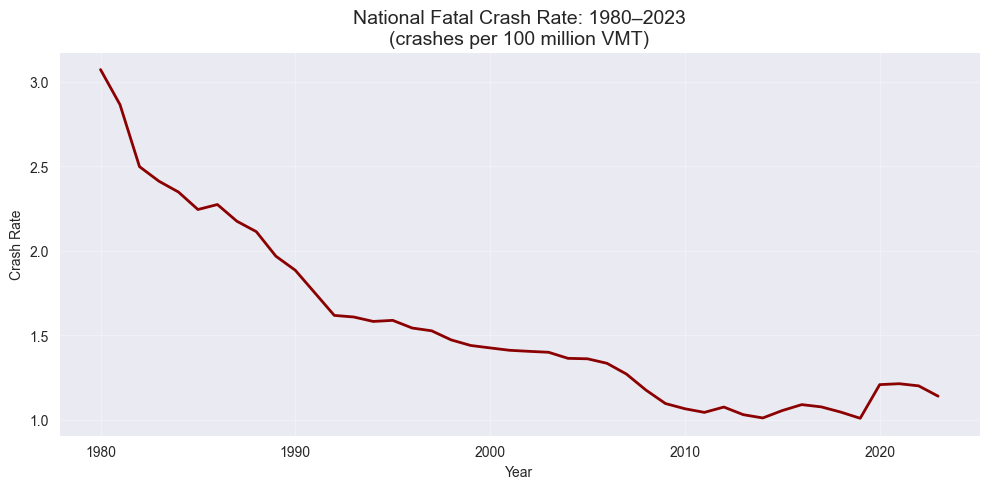

In [21]:
# Compute national average crash rate per year
national_trend = df.groupby('year')['crash_rate_per_100m_vmt'].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(national_trend['year'], national_trend['crash_rate_per_100m_vmt'],
         color='darkred', linewidth=2)
plt.title('National Fatal Crash Rate: 1980–2023\n(crashes per 100 million VMT)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Crash Rate')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The fatal crash rate per 100 million vehicle miles traveled (VMT) has **declined dramatically** since the 1980s — dropping from over 3.0 to around 1.1–1.2 in recent years.

This reflects decades of progress in automotive safety, including seat belts, airbags, anti-lock brakes, automated emergency braking, stricter drunk-driving laws, and improved road design. Despite rising vehicle miles traveled and increased distractions (e.g., smartphones), the risk per mile driven has fallen by nearly 65%. However, since 2010, the decline has slowed, suggesting emerging risks — such as climate impacts or distracted driving — may be offsetting earlier gains. This long-term trend must be accounted for when evaluating the role of weather in crash risk.

After decades of decline, the fatal crash rate began rising again after 2015, with a notable increase by 2018, likely due to distracted driving, larger vehicles, and more extreme weather.

## Crash Rate vs. Temperature (Scatter Plot)

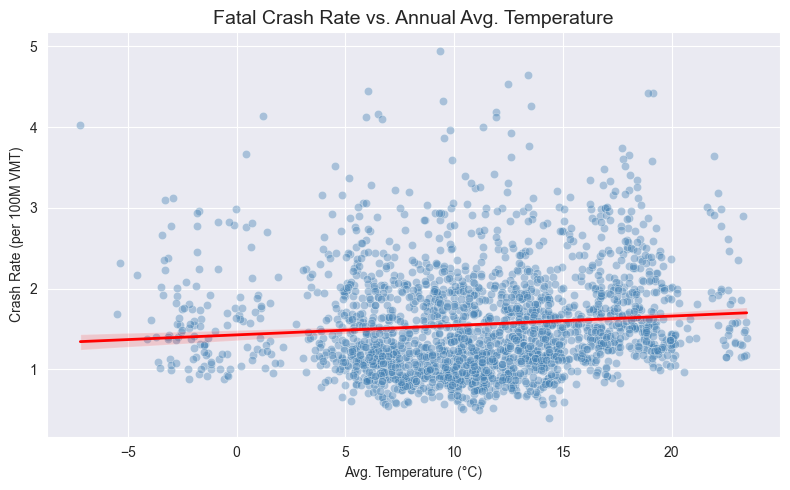

In [22]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,
    x='avg_temp_c',
    y='crash_rate_per_100m_vmt',
    alpha=0.4,
    color='steelblue'
)
# Add trend line
sns.regplot(
    data=df,
    x='avg_temp_c',
    y='crash_rate_per_100m_vmt',
    scatter=False,
    color='red',
    line_kws={'linewidth': 2}
)
plt.title('Fatal Crash Rate vs. Annual Avg. Temperature', fontsize=14)
plt.xlabel('Avg. Temperature (°C)')
plt.ylabel('Crash Rate (per 100M VMT)')
plt.tight_layout()
plt.show()

## Crash Rate vs. Precipitation

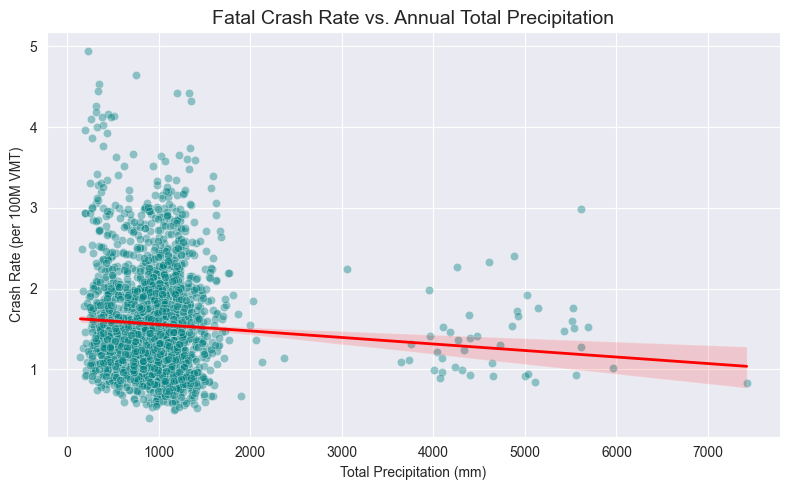

In [23]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,
    x='total_precip_mm',
    y='crash_rate_per_100m_vmt',
    alpha=0.4,
    color='teal'
)
sns.regplot(
    data=df,
    x='total_precip_mm',
    y='crash_rate_per_100m_vmt',
    scatter=False,
    color='red',
    line_kws={'linewidth': 2}
)
plt.title('Fatal Crash Rate vs. Annual Total Precipitation', fontsize=14)
plt.xlabel('Total Precipitation (mm)')
plt.ylabel('Crash Rate (per 100M VMT)')
plt.tight_layout()
plt.show()

## Map of Average Crash Rate by State

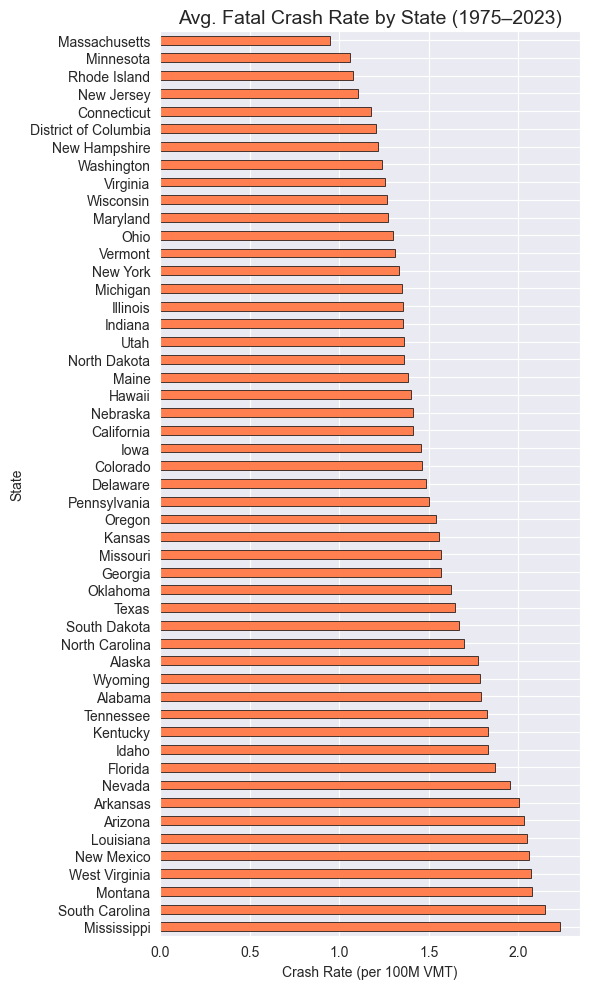

In [24]:
# Compute average crash rate per state
state_rates = df.groupby('state_name')['crash_rate_per_100m_vmt'].mean().sort_values(ascending=False)

plt.figure(figsize=(6, 10))
state_rates.plot(kind='barh', color='coral', edgecolor='black', linewidth=0.5)
plt.title('Avg. Fatal Crash Rate by State (1975–2023)', fontsize=14)
plt.xlabel('Crash Rate (per 100M VMT)')
plt.ylabel('State')
plt.tight_layout()
plt.show()

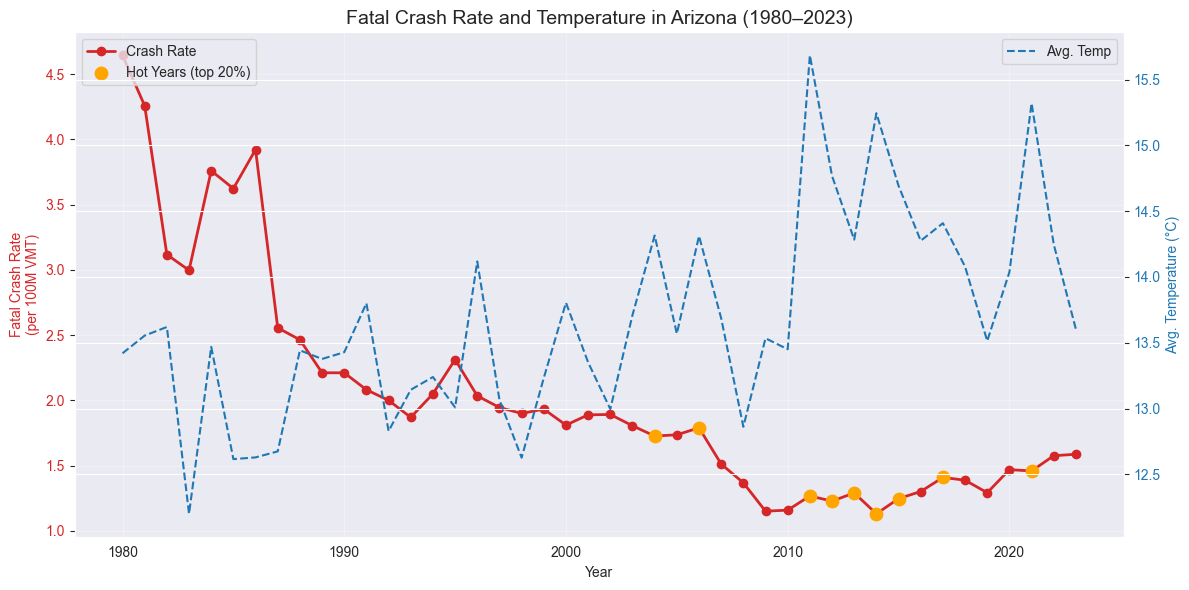

In [25]:
STATE = "Arizona"

# Filter data
state_data = df[df['state_name'] == STATE].copy()
state_data = state_data.sort_values('year')

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot crash rate
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Fatal Crash Rate\n(per 100M VMT)', color=color)
ax1.plot(state_data['year'], state_data['crash_rate_per_100m_vmt'],
         color=color, marker='o', linewidth=2, label='Crash Rate')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(alpha=0.3)

# Create second y-axis for temperature
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Avg. Temperature (°C)', color=color)
ax2.plot(state_data['year'], state_data['avg_temp_c'],
         color=color, linestyle='--', linewidth=1.5, label='Avg. Temp')
ax2.tick_params(axis='y', labelcolor=color)

# Highlight hot years (optional)
hot_threshold = state_data['avg_temp_c'].quantile(0.8)  # top 20% hottest
hot_years = state_data[state_data['avg_temp_c'] >= hot_threshold]
ax1.scatter(hot_years['year'], hot_years['crash_rate_per_100m_vmt'],
            color='orange', s=80, zorder=5, label='Hot Years (top 20%)')

# Final touches
plt.title(f'Fatal Crash Rate and Temperature in {STATE} (1980–2023)', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
fig.tight_layout()
plt.show()

This graph shows how the fatal crash rate (per 100 million vehicle miles traveled) and average annual temperature have changed over time in a single U.S. state—for example, Arizona—from 1975 to 2023. The red line represents the state’s yearly fatal crash risk, while the blue dashed line shows the average temperature for that same year. Orange dots highlight the state’s hottest years (typically the top 20% of temperatures during this period).

When interpreting this graph, look for whether hotter years tend to coincide with higher crash rates. For instance, if several orange dots (hot years) align with peaks in the red crash-rate line, it suggests that elevated temperatures may be associated with increased traffic fatalities in that state.

In [26]:
def plot_weather_crash_trends(df, state_name):
    """
    Create a multi-axis time series plot showing crash rate and weather variables for a single state.

    Parameters:
    - df: DataFrame with columns ['state_name', 'year', 'crash_rate_per_100m_vmt',
                                 'avg_temp_c', 'total_precip_mm', 'avg_wind_speed_ms']
    - state_name: Name of the state to plot (e.g., "Arizona", "Texas", "Florida")
    """
    import pandas as pd
    import matplotlib.pyplot as plt

    # Filter data for the specified state
    state_data = df[df['state_name'] == state_name].sort_values('year').copy()

    if state_data.empty:
        print(f"No data found for state: {state_name}")
        return

    # Define thresholds for extreme conditions (top 20%)
    temp_threshold = state_data['avg_temp_c'].quantile(0.8)
    precip_threshold = state_data['total_precip_mm'].quantile(0.8)
    wind_threshold = state_data['avg_wind_speed_ms'].quantile(0.8)

    # Mark extreme years
    state_data['is_hot'] = state_data['avg_temp_c'] >= temp_threshold
    state_data['is_wet'] = state_data['total_precip_mm'] >= precip_threshold
    state_data['is_windy'] = state_data['avg_wind_speed_ms'] >= wind_threshold

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot crash rate (main line)
    color_crash = 'darkred'
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('Fatal Crash Rate\n(per 100M VMT)', color=color_crash, fontsize=12)
    ax1.plot(state_data['year'], state_data['crash_rate_per_100m_vmt'],
             color=color_crash, linewidth=2.5, label='Crash Rate', zorder=5)
    ax1.tick_params(axis='y', labelcolor=color_crash)
    ax1.grid(alpha=0.2, linestyle='--')

    # Plot temperature (secondary y-axis)
    ax2 = ax1.twinx()
    color_temp = 'tab:orange'
    ax2.set_ylabel('Avg. Temperature (°C)', color=color_temp, fontsize=12)
    ax2.plot(state_data['year'], state_data['avg_temp_c'],
             color=color_temp, linewidth=1.5, linestyle='--', label='Avg. Temp')
    ax2.tick_params(axis='y', labelcolor=color_temp)

    # Plot precipitation (third y-axis)
    ax3 = ax1.twinx()
    color_precip = 'tab:blue'
    ax3.spines['right'].set_position(('outward', 60))  # Offset third axis
    ax3.set_ylabel('Total Precipitation (mm)', color=color_precip, fontsize=12)
    ax3.plot(state_data['year'], state_data['total_precip_mm'],
             color=color_precip, linewidth=1.5, linestyle='-.', label='Precipitation')
    ax3.tick_params(axis='y', labelcolor=color_precip)

    # Plot wind speed (fourth y-axis)
    ax4 = ax1.twinx()
    color_wind = 'tab:green'
    ax4.spines['right'].set_position(('outward', 120))  # Further offset
    ax4.set_ylabel('Avg. Wind Speed (m/s)', color=color_wind, fontsize=12)
    ax4.plot(state_data['year'], state_data['avg_wind_speed_ms'],
             color=color_wind, linewidth=1.5, linestyle=':', label='Wind Speed')
    ax4.tick_params(axis='y', labelcolor=color_wind)

    # Highlight extreme years with markers
    ax1.scatter(state_data[state_data['is_hot']]['year'],
                state_data[state_data['is_hot']]['crash_rate_per_100m_vmt'],
                color='red', s=80, marker='^', label='Hot Year', alpha=0.8, zorder=6)

    ax1.scatter(state_data[state_data['is_wet']]['year'],
                state_data[state_data['is_wet']]['crash_rate_per_100m_vmt'],
                color='blue', s=80, marker='s', label='Wet Year', alpha=0.8, zorder=6)

    ax1.scatter(state_data[state_data['is_windy']]['year'],
                state_data[state_data['is_windy']]['crash_rate_per_100m_vmt'],
                color='green', s=80, marker='D', label='Windy Year', alpha=0.8, zorder=6)

    # Final styling
    plt.title(f'Crash Risk and Weather Trends in {state_name} (1980–2023)', fontsize=16, fontweight='bold')
    ax1.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncol=2)
    ax2.legend(loc='upper left', bbox_to_anchor=(0.3, 1.15), ncol=1)
    ax3.legend(loc='upper left', bbox_to_anchor=(0.55, 1.15), ncol=1)
    ax4.legend(loc='upper left', bbox_to_anchor=(0.8, 1.15), ncol=1)

    fig.tight_layout(rect=[0, 0, 1, 0.95])  # Make room for legend
    plt.show()

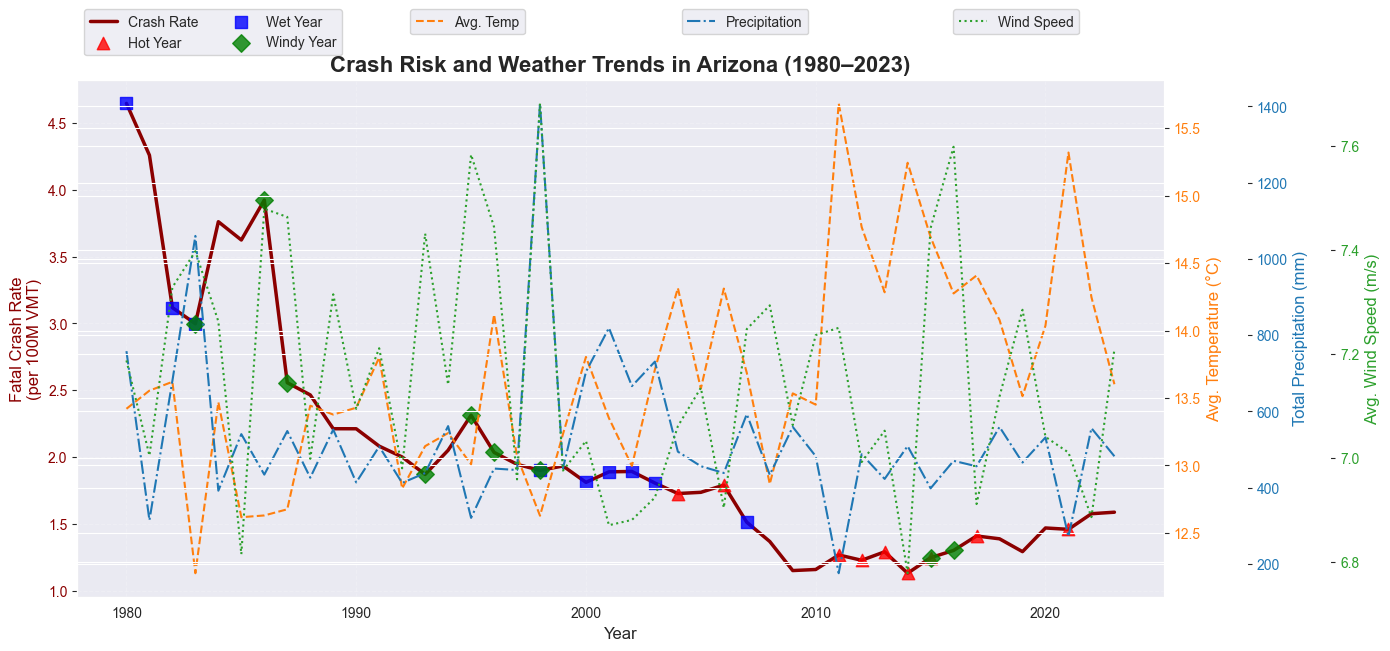

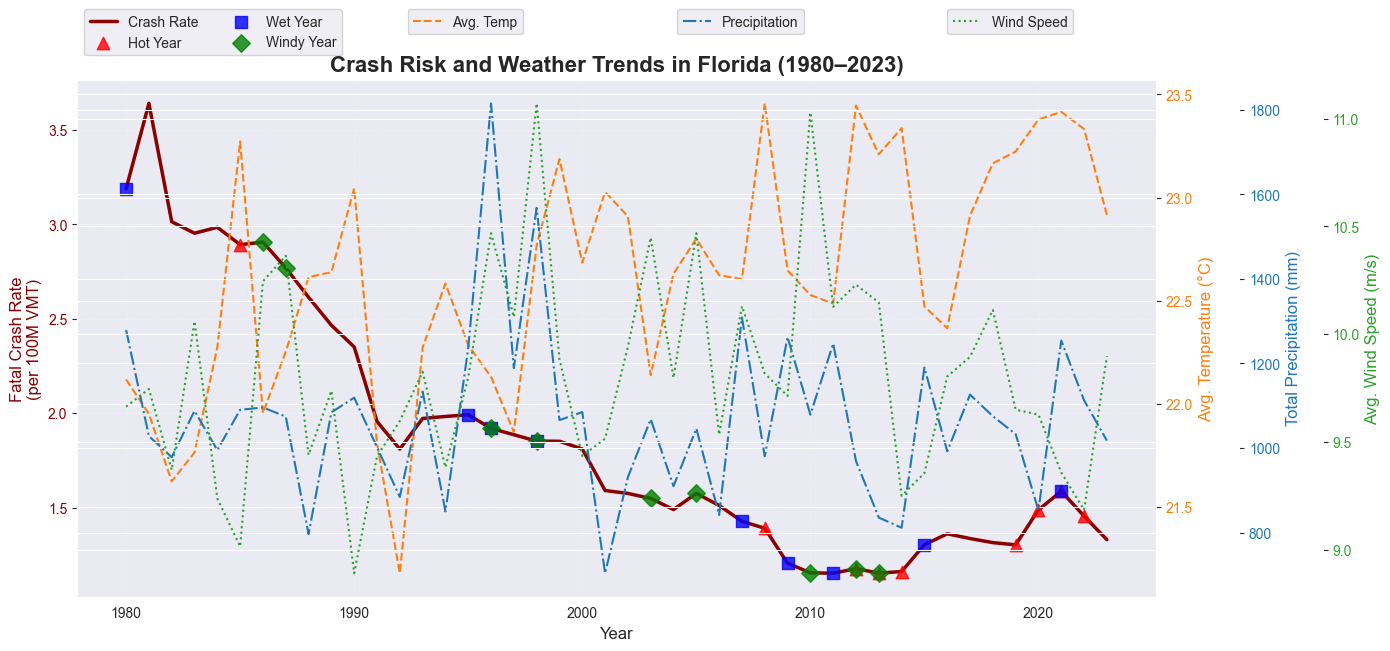

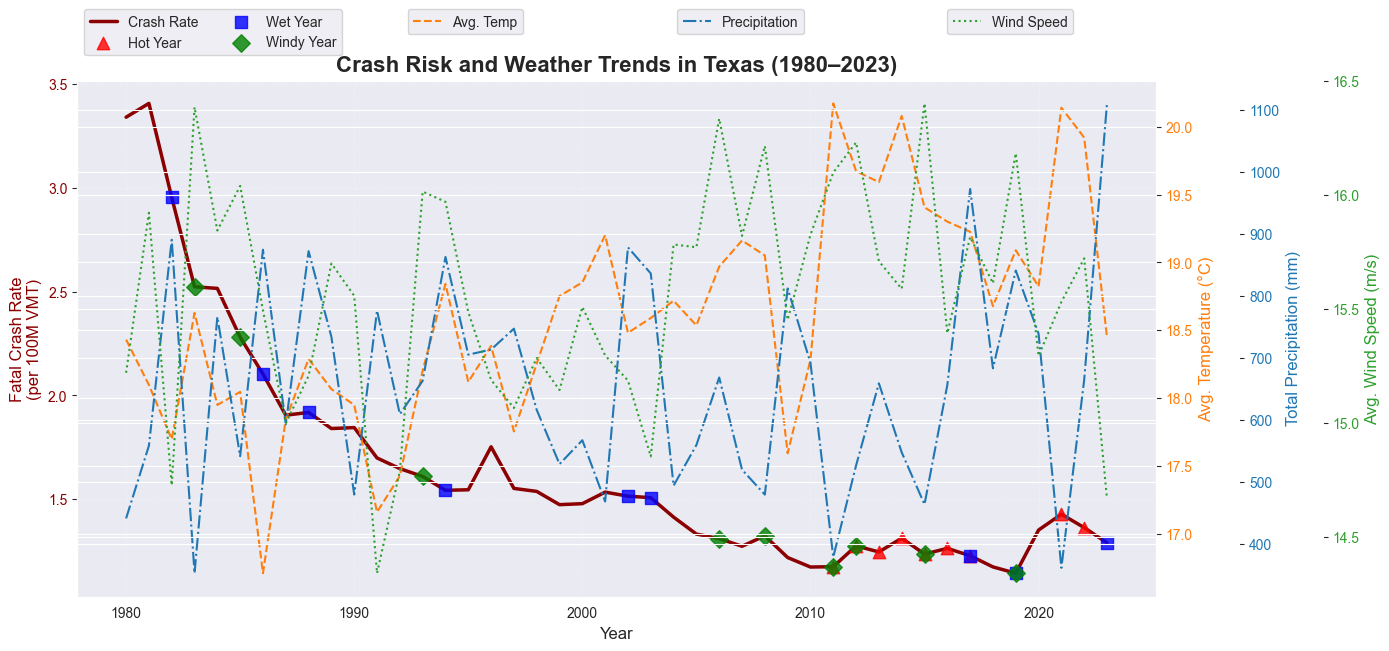

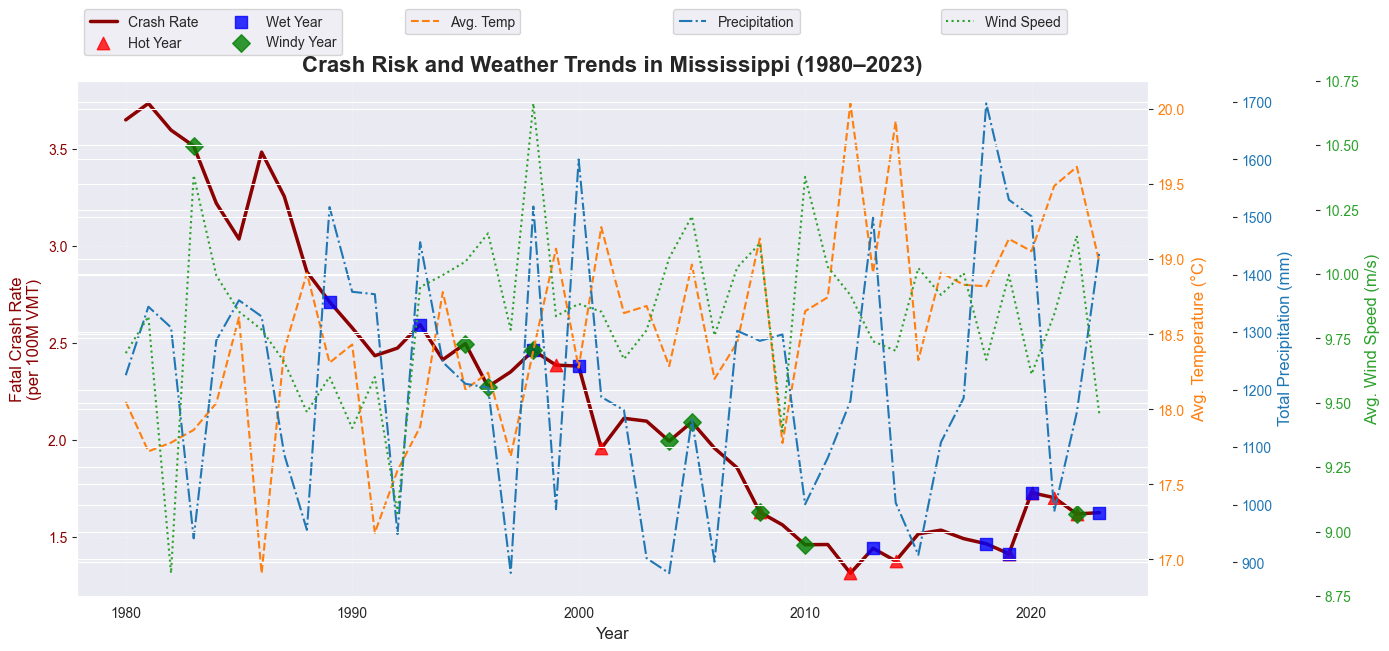

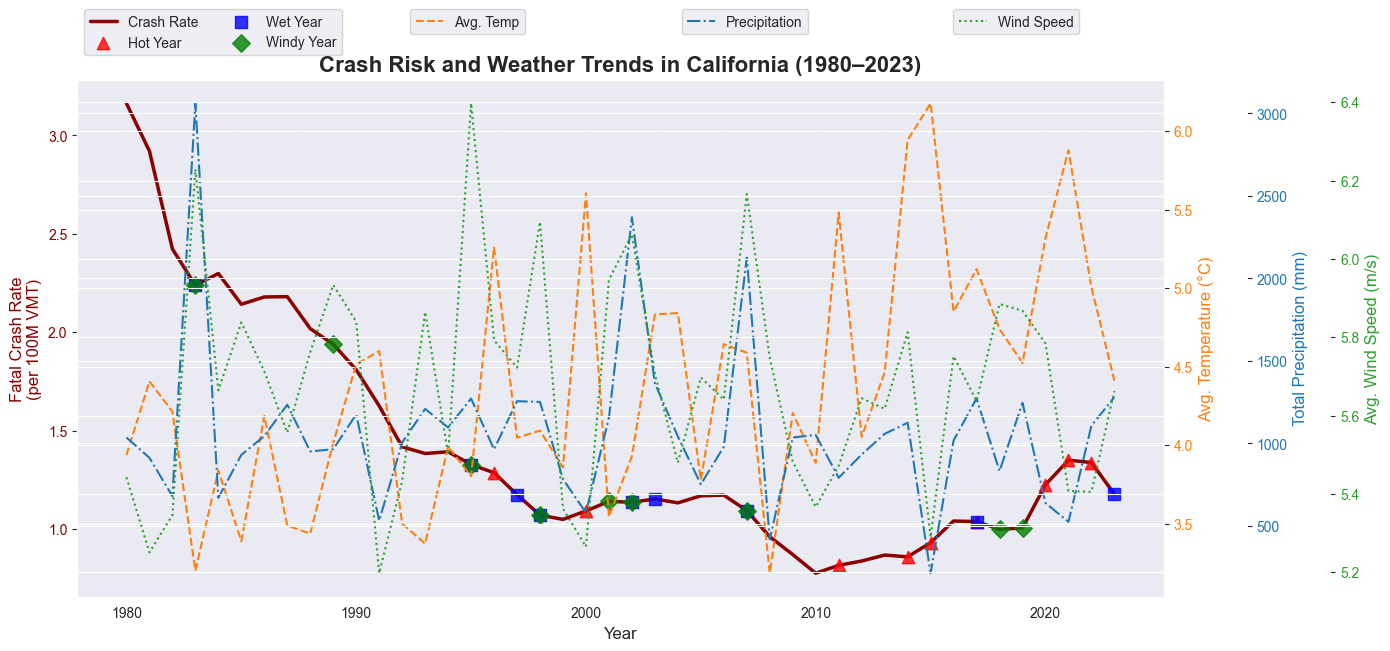

In [27]:
plot_weather_crash_trends(df, "Arizona")
plot_weather_crash_trends(df, "Florida")
plot_weather_crash_trends(df, "Texas")
plot_weather_crash_trends(df, "Mississippi")
plot_weather_crash_trends(df, "California")


This graph displays the year-by-year evolution of fatal crash risk (red line) alongside three key weather variables — average temperature (orange), total precipitation (blue), and average wind speed (green) — for a single state over nearly 50 years. Each weather variable is plotted on its own vertical axis to avoid overlap, while crash rate remains on the primary axis for direct comparison. Extreme years — defined as the hottest, wettest, or windiest 20% of years — are marked with distinct symbols: triangles for heat, squares for rain, and diamonds for wind. By examining this visualization, we can identify whether specific weather extremes consistently coincide with spikes in crash risk. For example, if a very wet year (blue square) aligns with a peak in crash rate, it suggests heavy precipitation may increase collision risk.

# Data Modeling

Main question: **Does hotter, wetter, or windier weather make driving more dangerous per mile driven?**

--> Here’s the weather, the year, and where it is. Guess how dangerous driving was that year

In [28]:
# Define features (X) and target (y)
feature_cols = ['year', 'avg_temp_c', 'total_precip_mm', 'avg_wind_speed_ms', 'latitude', 'longitude']
X = df[feature_cols]
y = df['crash_rate_per_100m_vmt']

In [29]:
# STEP 3: Split into train (1980–2018) and test (2019–2023)
train_mask = df['year'] <= 2018
test_mask = df['year'] > 2018

In [30]:
X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

In [31]:
print(f"\nTraining on {len(X_train)} samples (1980–2018)")
print(f"Testing on {len(X_test)} samples (2019–2023)")


Training on 1989 samples (1980–2018)
Testing on 255 samples (2019–2023)


one sample = one row in the dataset

--> One U.S. state in one year, with its Weather (average temperature, total precipitation, average wind speed), Location (latitude, longitude), Year (1980–2023), Fatal crash rate (per 100 million miles driven)

In [32]:
X_train.head()

,year,avg_temp_c,total_precip_mm,avg_wind_speed_ms,latitude,longitude
0,1980,18.045027,1235.245361,8.992018,32.3182,-86.9023
1,1980,-1.734674,466.319275,8.910186,64.2008,-149.4853
2,1980,13.420449,758.078552,7.187393,34.0489,-111.0937
3,1980,16.949562,855.259521,9.794807,34.7996,-92.1849
4,1980,3.937228,1035.248413,5.442434,37.2719,-119.2702


In [33]:
# Train the model
model = XGBRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [34]:
# Make predictions on test data (2019–2023)
y_pred = model.predict(X_test)

# Evaluate accuracy
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
avg_real = y_test.mean()

print(f"Model Results:")
print(f"Average actual crash rate (2019–2023): {avg_real:.3f} per 100M VMT")
print(f"Mean Absolute Error (MAE):           {mae:.3f}")
print(f"Relative error:                      {mae / avg_real:.1%}")

Model Results:
Average actual crash rate (2019–2023): 1.153 per 100M VMT
Mean Absolute Error (MAE):           0.145
Relative error:                      12.6%


From results we can conclude:
- In the U.S. from 2019 to 2023, there were on average 1.153 fatal crashes per 100 million miles driven.
- **MAE = 0.145** --> Model’s predictions are, on average, off by 0.145 crashes per 100M VMT
- **Relative Error = 12.6%** --> On average, model’s prediction is 12.6% higher or lower than the actual fatal crash rate.

## Feature importance

In [35]:
# Feature importance
feature_names = ['year', 'avg_temp_c', 'total_precip_mm', 'avg_wind_speed_ms', 'latitude', 'longitude']
importances = model.feature_importances_

feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("🔍 Most important factors in predicting crash risk:")
print(feat_imp)

🔍 Most important factors in predicting crash risk:
             Feature  Importance
0               year    0.384523
4           latitude    0.339304
5          longitude    0.208677
3  avg_wind_speed_ms    0.027767
2    total_precip_mm    0.020620
1         avg_temp_c    0.019109


Despite the influence of weather, the strongest predictors of fatal crash risk are **year** (reflecting long-term safety improvements), **latitude, and longitude** — indicating that geographic and structural factors dominate crash risk patterns across the U.S., while temperature, precipitation, and wind play only minor, secondary roles.

In [36]:
df['is_extreme_heat_year'] = df.groupby('state_id')['avg_temp_c'].transform(
    lambda x: x > x.quantile(0.9)
).astype(int)

# Ponovi model sa ovom varijablom umjesto avg_temp_c
X_new = df[['year', 'latitude', 'longitude', 'is_extreme_heat_year']]
y = df['crash_rate_per_100m_vmt']

model_new = XGBRegressor(n_estimators=200, random_state=42)
model_new.fit(X_new, y)

# Provjeri važnost
feat_imp = pd.Series(model_new.feature_importances_, index=X_new.columns).sort_values(ascending=False)
print(feat_imp)

year                    0.559684
longitude               0.219433
latitude                0.209636
is_extreme_heat_year    0.011248
dtype: float32
